In [1]:
import ray

import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np

from torch.autograd import Variable
from torch.nn import functional as F
from scipy.stats import entropy

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Training parameters
dataroot = ray.utils.get_user_temp_dir() + os.sep
workers = 2
batch_size = 64
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# iterations of actual training in each Trainable _train
train_iterations_per_step = 5

MODEL_PATH = os.path.expanduser("~/.ray/models/mnist_cnn.pt")


def get_data_loader():
    dataset = dset.MNIST(
        root=dataroot,
        download=True,
        transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, )),
        ]))

    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

    return dataloader


# __GANmodel_begin__
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh())

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False), nn.Sigmoid())

    def forward(self, input):
        return self.main(input)


# __GANmodel_end__


# __INCEPTION_SCORE_begin__
class Net(nn.Module):
    """
    LeNet for MNist classification, used for inception_score
    """

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def inception_score(imgs, mnist_model_ref, batch_size=32, splits=1):
    N = len(imgs)
    dtype = torch.FloatTensor
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)
    cm = ray.get(mnist_model_ref)  # Get the mnist model from Ray object store.
    up = nn.Upsample(size=(28, 28), mode="bilinear").type(dtype)

    def get_pred(x):
        x = up(x)
        x = cm(x)
        return F.softmax(x).data.cpu().numpy()

    preds = np.zeros((N, 10))
    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]
        preds[i * batch_size:i * batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits):(k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


# __INCEPTION_SCORE_end__


def train(netD, netG, optimG, optimD, criterion, dataloader, iteration, device,
          mnist_model_ref):
    real_label = 1
    fake_label = 0

    for i, data in enumerate(dataloader, 0):
        if i >= train_iterations_per_step:
            break

        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full(
            (b_size, ), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimG.step()

        is_score, is_std = inception_score(fake, mnist_model_ref)

        # Output training stats
        if iteration % 10 == 0:
            print("[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z))"
                  ": %.4f / %.4f \tInception score: %.4f" %
                  (iteration, len(dataloader), errD.item(), errG.item(), D_x,
                   D_G_z1, D_G_z2, is_score))

    return errG.item(), errD.item(), is_score


def plot_images(dataloader):
    # Plot some training images
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Original Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(real_batch[0][:64], padding=2,
                             normalize=True).cpu(), (1, 2, 0)))

    plt.show()


def demo_gan(checkpoint_paths):
    img_list = []
    fixed_noise = torch.randn(64, nz, 1, 1)
    for netG_path in checkpoint_paths:
        loadedG = Generator()
        loadedG.load_state_dict(torch.load(netG_path)["netGmodel"])
        with torch.no_grad():
            fake = loadedG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)]
           for i in img_list]
    ani = animation.ArtistAnimation(
        fig, ims, interval=1000, repeat_delay=1000, blit=True)
    ani.save("./generated.gif", writer="imagemagick", dpi=72)
    plt.show()

In [2]:
ray.init()


2020-11-26 15:04:11,003	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8273


{'node_ip_address': '192.168.1.34',
 'raylet_ip_address': '192.168.1.34',
 'redis_address': '192.168.1.34:40104',
 'object_store_address': '/tmp/ray/session_2020-11-26_15-04-10_394777_7080/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-26_15-04-10_394777_7080/sockets/raylet',
 'webui_url': '127.0.0.1:8273',
 'session_dir': '/tmp/ray/session_2020-11-26_15-04-10_394777_7080',
 'metrics_export_port': 62207}

Trial name,status,loc,netD_lr,netG_lr,iter,total time (s),lossg,lossd,is_score
dcgan_train_aed65_00000,TERMINATED,,0.0004,0.00012,5,20.3393,1.47156,0.933592,1.0485
dcgan_train_aed65_00001,TERMINATED,,0.0005,0.0002,5,22.6444,3.39241,1.6219,1.71006
dcgan_train_aed65_00002,TERMINATED,,0.0005,0.0001,5,22.9693,1.21018,1.30843,1.26672
dcgan_train_aed65_00003,TERMINATED,,0.0005,0.0002,5,22.0767,3.56917,2.2807,1.07185
dcgan_train_aed65_00004,TERMINATED,,0.0005,0.0002,5,22.5935,3.30237,0.88252,1.23914
dcgan_train_aed65_00005,TERMINATED,,0.00024,0.00024,5,19.4302,5.61565,0.0745955,1.09978
dcgan_train_aed65_00006,TERMINATED,,0.0002,0.0002,5,20.6026,6.45921,0.0174532,1.03852
dcgan_train_aed65_00007,TERMINATED,,0.0001,0.0005,5,22.2228,5.77912,1.84591,1.12042


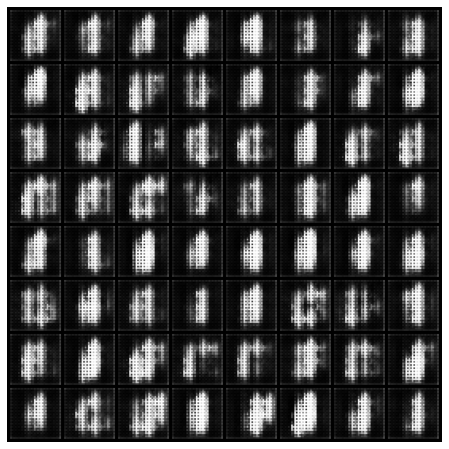

In [6]:
import ray
from ray import tune
from ray.tune.schedulers import PopulationBasedTraining

import argparse
import os
from filelock import FileLock
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import numpy as np

# __Train_begin__
def dcgan_train(config, checkpoint_dir=None):
    step = 0
    use_cuda = config.get("use_gpu") and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    netD = Discriminator().to(device)
    netD.apply(weights_init)
    netG = Generator().to(device)
    netG.apply(weights_init)
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(
        netD.parameters(), lr=config.get("lr", 0.01), betas=(beta1, 0.999))
    optimizerG = optim.Adam(
        netG.parameters(), lr=config.get("lr", 0.01), betas=(beta1, 0.999))
    with FileLock(os.path.expanduser("~/.data.lock")):
        dataloader = get_data_loader()

    if checkpoint_dir is not None:
        path = os.path.join(checkpoint_dir, "checkpoint")
        checkpoint = torch.load(path)
        netD.load_state_dict(checkpoint["netDmodel"])
        netG.load_state_dict(checkpoint["netGmodel"])
        optimizerD.load_state_dict(checkpoint["optimD"])
        optimizerG.load_state_dict(checkpoint["optimG"])
        step = checkpoint["step"]

        if "netD_lr" in config:
            for param_group in optimizerD.param_groups:
                param_group["lr"] = config["netD_lr"]
        if "netG_lr" in config:
            for param_group in optimizerG.param_groups:
                param_group["lr"] = config["netG_lr"]

    while True:
        lossG, lossD, is_score = train(netD, netG, optimizerG, optimizerD,
                                       criterion, dataloader, step, device,
                                       config["mnist_model_ref"])
        step += 1
        with tune.checkpoint_dir(step=step) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save({
                "netDmodel": netD.state_dict(),
                "netGmodel": netG.state_dict(),
                "optimD": optimizerD.state_dict(),
                "optimG": optimizerG.state_dict(),
                "step": step,
            }, path)
        tune.report(lossg=lossG, lossd=lossD, is_score=is_score)


# __Train_end__

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--smoke-test", action="store_true", help="Finish quickly for testing")
    args, _ = parser.parse_known_args()

    import urllib.request
    # Download a pre-trained MNIST model for inception score calculation.
    # This is a tiny model (<100kb).
    if not os.path.exists(MODEL_PATH):
        print("downloading model")
        os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
        urllib.request.urlretrieve(
            "https://github.com/ray-project/ray/raw/master/python/ray/tune/"
            "examples/pbt_dcgan_mnist/mnist_cnn.pt", MODEL_PATH)

    dataloader = get_data_loader()
    if not args.smoke_test:
        plot_images(dataloader)

    # __tune_begin__

    # load the pretrained mnist classification model for inception_score
    mnist_cnn = Net()
    mnist_cnn.load_state_dict(torch.load(MODEL_PATH))
    mnist_cnn.eval()
    # Put the model in Ray object store.
    mnist_model_ref = ray.put(mnist_cnn)

    scheduler = PopulationBasedTraining(
        perturbation_interval=5,
        hyperparam_mutations={
            # distribution for resampling
            "netG_lr": lambda: np.random.uniform(1e-2, 1e-5),
            "netD_lr": lambda: np.random.uniform(1e-2, 1e-5),
        })

    tune_iter = 5 if args.smoke_test else 5
    analysis = tune.run(
        dcgan_train,
        name="pbt_dcgan_mnist",
        scheduler=scheduler,
        verbose=1,
        stop={
            "training_iteration": tune_iter,
        },
        metric="is_score",
        mode="max",
        num_samples=8,
        config={
            "netG_lr": tune.choice([0.0001, 0.0002, 0.0005]),
            "netD_lr": tune.choice([0.0001, 0.0002, 0.0005]),
            "mnist_model_ref": mnist_model_ref
        })
    # __tune_end__

    # demo of the trained Generators
    if not args.smoke_test:
        all_trials = analysis.trials
        checkpoint_paths = [
            os.path.join(analysis.get_best_checkpoint(t), "checkpoint")
            for t in all_trials
        ]
        demo_gan(checkpoint_paths)

In [ ]:
from ray.tune.logger import *
supernombre=0;
class TestLogger(tune.logger.Logger):
    def _init(self):
        progress_file = os.path.join("/home/antoine/Projet/NovelTuning/", str(supernombre)+".csv")
        self._continuing = os.path.exists(progress_file)
        self._file = open(progress_file, "a")
        self._csv_out = None
    def on_result(self, result):
        tmp = result.copy()
        #if "done" in tmp:
         #   if(tmp["done"] != True):

        if "config" in tmp:
            del tmp["config"]
        result = flatten_dict(tmp, delimiter="/")
        if self._csv_out is None:
            self._csv_out = csv.DictWriter(self._file, result.keys())
            if not self._continuing:
                self._csv_out.writeheader()
        self._csv_out.writerow(
            {k: v
             for k, v in result.items() if k in self._csv_out.fieldnames})
        self._file.flush()
                                         
for i in range(0,7):
    supernombre=i
    GAN_MNIST(i)

In [ ]:

#Configs
parser = argparse.ArgumentParser()
parser.add_argument(
    "--smoke-test", action="store_true", help="Finish quickly for testing")
args, _ = parser.parse_known_args()          
        
    
tune_kwargs = {
    "num_samples": NUM_TUNED if args.smoke_test else NUM_TUNED,
    "config": {
    "steps": ITERATIONS,  # evaluation times
     "lr":  tune.uniform(1e-4, 0.1 ),#,1e-4), #*10
         "weight_decay":tune.uniform(1e-4, 0.1),#,1e-4), #*10 et 0
        "sigmoid_func":tune.uniform(0,1),
        "hidden_dim":tune.uniform(32.,256.),#,1), #log de 32 à 256
        "n_layer":tune.uniform(1,3),#,1), #from 1 to 3
        "droupout_prob":tune.uniform(0,0.5),#,0.1), #0.x pour x allant de 0 à 5     
        "adam":tune.uniform(0,1),
        "model":tune.uniform(0,1)
    }
}


experiment_metrics= dict(metric="is_score",
    mode="max")


dim_dict = {
    "netG_lr": (ValueType.CONTINUOUS, [0, 0.1], 1e-2),
    "netD_lr": (ValueType.CONTINUOUS, [0, 0.1], 1e-2)
}

config =     {
        "netG_lr": tune.loguniform(1e-10, 0.1),
       "netD_lr": tune.loguniform(1e-10, 0.1)
    }

algo = NevergradSearch(optimizer=ng.optimizers.OnePlusOne)


tune_iter = 5 if args.smoke_test else 1
#c={"mnist_model_ref" : mnist_model_ref}

    

    
#experiment_metrics = dict(metric="mean_accuracy", mode="max")


ITERATIONS = 10
NUM_TUNED= 1
    


#[nn.ReLU, nn.Softmax(), nn.Tanh(),nn.Sigmoid() ]

tune_kwargs = {
    "num_samples": 1 if True else 2,
    "config": {
    "steps": 3,  # evaluation times
     "lr":  tune.quniform(1e-10, 0.1,1e-10),
    "b1": tune.quniform(0.9, 1-1e-10,1e-10),
        "b2":tune.quniform(0.9, 1-1e-10,1e-10),
        "eps": tune.uniform(1e-10, 0.1),
         "weight_decay":tune.quniform(1e-10, 0.1,1e-10),
        "sigmoid_func":nn.ReLU()
    }
}

tune_kwargs = {
    "num_samples": NUM_TUNED if args.smoke_test else NUM_TUNED,
    "config": {
    "steps": ITERATIONS,  # evaluation times
     "lr":  tune.loguniform(1e-10, 0.1),
    "b1": tune.loguniform(0.9, 1-1e-10),
        "b2":tune.loguniform(0.9, 1-1e-10),
        "eps": tune.loguniform(1e-10, 0.1),
         "weight_decay":tune.loguniform(1e-10, 0.1)
    }
}
   
#i is in [0;1]
#We want all values between 0 and 1
def get_sigmoid_func(i):
    if(i<0.33):
        return nn.ReLU()
    elif(i<0.67):
        return nn.Tanh()
    else:
        return nn.Sigmoid()

    
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))    
    
def get_loos_func(i):
        return nn.MSELoss()


    
    


    
optimizer_is_adam = True   
    
f = get_sigmoid_func(3)
print(f(torch.randn(2)))
import random
tune_kwargs = {
    "num_samples": NUM_TUNED if args.smoke_test else NUM_TUNED,
    "config": {
    "steps": ITERATIONS,  # evaluation times
     "lr":  tune.loguniform(1e-4, 0.1 ),#,1e-4), #*10
         "weight_decay":tune.loguniform(1e-4, 0.1),#,1e-4), #*10 et 0
        "sigmoid_func":tune.uniform(0,1),
        "hidden_dim":tune.loguniform(32.,256.),#,1), #log de 32 à 256
        "n_layer":tune.uniform(1,3),#,1), #from 1 to 3
        "droupout_prob":tune.uniform(0,0.5),#,0.1), #0.x pour x allant de 0 à 5     
        "adam":tune.uniform(0,1)
    }
}

tune_kwargs = {
    "num_samples": NUM_TUNED if args.smoke_test else NUM_TUNED,
    "config": {
    "steps": ITERATIONS,  # evaluation times
     "lr":  tune.uniform(1e-4, 0.1 ),#,1e-4), #*10
         "weight_decay":tune.uniform(1e-4, 0.1),#,1e-4), #*10 et 0
        "sigmoid_func":tune.uniform(0,1),
        "hidden_dim":tune.uniform(32.,256.),#,1), #log de 32 à 256
        "n_layer":tune.uniform(1,3),#,1), #from 1 to 3
        "droupout_prob":tune.uniform(0,0.5),#,0.1), #0.x pour x allant de 0 à 5     
        "adam":tune.uniform(0,1),
        "model":tune.uniform(0,1)
    }
}






In [ ]:
            analysis = tune.run(
            PytorchTrainable,
            name="pbt_dcgan_mnist",
            scheduler=scheduler,
            reuse_actors=True,
            search_alg=algo,
            verbose=1,
            checkpoint_at_end=True,
            stop={
                "training_iteration": tune_iter,
            },
            num_samples=8,
            export_formats=[ExportFormat.MODEL],
            config={
                "netG_lr": tune.loguniform(1e-10, 0.1),
                "netD_lr": tune.loguniform(1e-10, 0.1)
            })

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')